In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
import platform
from matplotlib import font_manager, rc
import os
import joblib
from sklearn.metrics import r2_score
import matplotlib.dates as mdates

In [2]:
plt.rcParams["axes.unicode_minus"] = False

if platform.system() == "Darwin":  # macOS
    rc("font", family="AppleGothic")
elif platform.system() == "Windows":  # Windows
    font_path = "C:/Windows/Fonts/malgun.ttf"  # 맑은 고딕
    font_name = font_manager.FontProperties(fname=font_path).get_name()
    rc("font", family=font_name)
elif platform.system() == "Linux":  # Linux (Ubuntu, Docker 등)
    font_path = "fonts/NanumGothic.ttf"
    if not os.path.exists(font_path):
        st.error("NanumGothic.ttf 폰트 파일이 존재하지 않습니다. 'fonts' 폴더 내에 폰트 파일을 확인하세요.")
    font_name = font_manager.FontProperties(fname=font_path).get_name()
    rc("font", family=font_name)

#### 지역별 수출량 예측 모델

🚀 모델 또는 스케일러가 존재하지 않아 새로 학습합니다.
Epoch 1/600


/opt/anaconda3/envs/hi/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.2404
Epoch 2/600
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2232 
Epoch 3/600
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1636 
Epoch 4/600
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1322 
Epoch 5/600
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0525 
Epoch 6/600
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0387 
Epoch 7/600
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0419 
Epoch 8/600
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0307 
Epoch 9/600
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0261 
Epoch 10/600
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0287
Epoch 11/600
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0232 
Epoch 12/600
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0249 
Epoch 13/600
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0267 
Epoch 14/600
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0235 
Epoch 15/600
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0261 
Epoch 16/600
7/7 ━━━━━━━━━━━━━━━

그래프가 '../../images/result/미국 LSTM 지역별 수출량 예측_12개월.png'로 저장되었습니다.


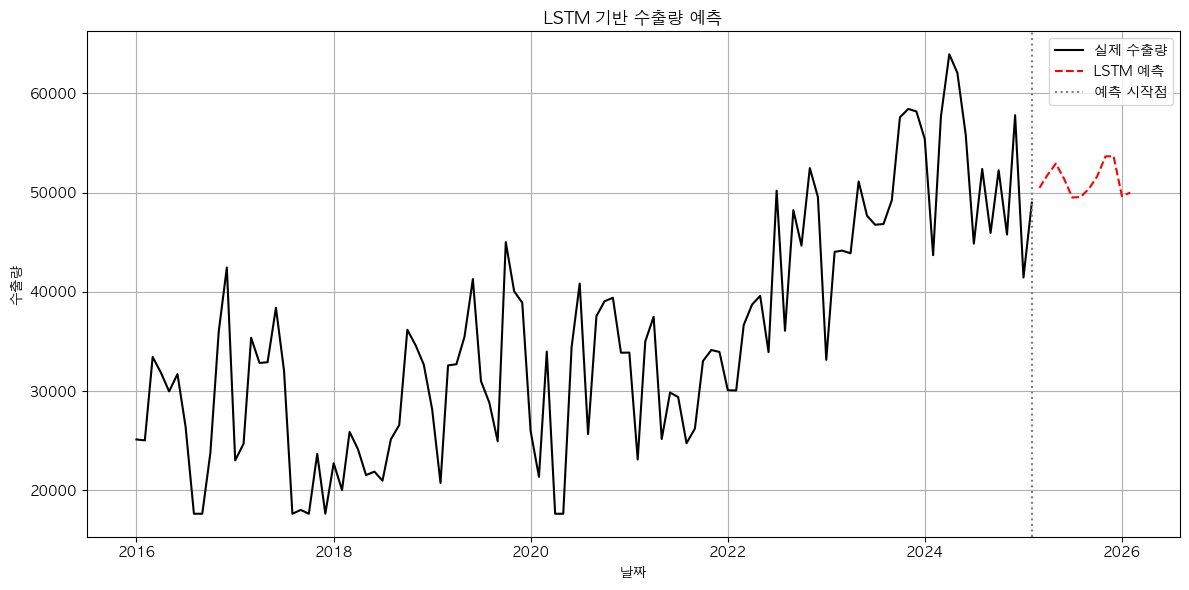

In [160]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# 1. 데이터 준비 함수
def prepare_lstm_data(series, time_steps=12):
    values = series['y'].values.reshape(-1, 1)
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(values)

    X, y = [], []
    for i in range(time_steps, len(scaled)):
        X.append(scaled[i-time_steps:i])
        y.append(scaled[i])
    X, y = np.array(X), np.array(y)
    return X, y, scaler

# 2. 모델 정의 및 학습
def train_lstm_model(X, y, units=50, epochs=600, batch_size=16):
    model = Sequential()
    model.add(LSTM(units=units, activation='relu', input_shape=(X.shape[1], X.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=1)
    return model

# 3. 미래 예측
def forecast_lstm(model, series, forecast_months, scaler, time_steps=12):
    data = scaler.transform(series['y'].values.reshape(-1, 1))
    last_sequence = data[-time_steps:]

    predictions = []
    for _ in range(forecast_months):
        input_seq = last_sequence.reshape(1, time_steps, 1)
        pred = model.predict(input_seq, verbose=0)
        predictions.append(pred[0, 0])
        last_sequence = np.append(last_sequence[1:], pred, axis=0)

    forecast_scaled = np.array(predictions).reshape(-1, 1)
    forecast_values = scaler.inverse_transform(forecast_scaled)

    last_date = series.index[-1]
    future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_months, freq='MS')

    result = pd.DataFrame({
        '연도': future_dates.year,
        '월': future_dates.month,
        '예측 수출량': forecast_values.flatten()
    })
    return result

# 4. 시각화 함수
def plot_lstm_forecast(series, forecast_df, region_name, forecast_months, save_path=None):
    forecast_index = pd.to_datetime(forecast_df['연도'].astype(str) + '-' + forecast_df['월'].astype(str))
    forecast_values = forecast_df['예측 수출량'].values

    plt.figure(figsize=(12, 6))
    plt.plot(series.index, series['y'], label='실제 수출량', color='black')
    plt.plot(forecast_index, forecast_values, label='LSTM 예측', color='red', linestyle='--')
    plt.axvline(x=series.index[-1], color='gray', linestyle=':', label='예측 시작점')
    plt.title("LSTM 기반 수출량 예측")
    plt.xlabel("날짜")
    plt.ylabel("수출량")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    save_path = f"../../images/result/{region_name} LSTM 지역별 수출량 예측_{forecast_months}개월.png"

    # 이미지 저장
    if save_path:
        plt.savefig(save_path, dpi=300)  # 해상도 조정 가능
        print(f"그래프가 '{save_path}'로 저장되었습니다.")

    plt.show()

# 5. 실행 예시
file_path = "../../data/processed/현대_지역별수출실적_전처리.csv"
df = pd.read_csv(file_path)

# 전처리: 지역명 + 대륙 통합
df = df.drop(columns=['대륙'])
cols = ['지역명'] + [col for col in df.columns if col != '지역명']
df = df[cols]

region_name = "미국"
forecast_months = 12

region_data = df[df['지역명'] == region_name].iloc[:, 1:].T
region_data.columns = ['y']
region_data.index = pd.to_datetime(region_data.index)
region_data = region_data.asfreq('MS')
region_data['y'] = pd.to_numeric(region_data['y'], errors='coerce')
region_data = region_data.dropna()

def get_model_path(region_name):
    return f"../../models/lstm_region_{region_name}_model.h5"

def get_scaler_path(region_name):
    return f"../../models/lstm_region_{region_name}_scaler.pkl"

def ensure_model(region_name):
    model_path = get_model_path(region_name)
    scaler_path = get_scaler_path(region_name)

    if os.path.exists(model_path) and os.path.exists(scaler_path):
        print(f"✅ 저장된 모델과 스케일러가 존재합니다: {model_path}")
        return True
    else:
        print(f"🚀 모델 또는 스케일러가 존재하지 않아 새로 학습합니다.")
        return False

status = ensure_model(region_name)

if status:
    lstm_model = load_model(f"../../models/lstm_region_{region_name}_model.h5", compile=False)
    scaler = joblib.load(f"../../models/lstm_region_{region_name}_scaler.pkl")
else:
    X, y, scaler = prepare_lstm_data(region_data)
    lstm_model = train_lstm_model(X, y)
    lstm_model.save(f"../../models/lstm_region_{region_name}_model.h5")
    joblib.dump(scaler, f"../../models/lstm_region_{region_name}_scaler.pkl")

lstm_forecast = forecast_lstm(lstm_model, region_data, forecast_months, scaler)
plot_lstm_forecast(region_data, lstm_forecast, region_name, forecast_months)

#### 차종별 판매량 예측 모델

🚀 모델 또는 스케일러가 존재하지 않아 새로 학습합니다.
Epoch 1/600


/opt/anaconda3/envs/hi/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0436  
Epoch 2/600
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0288 
Epoch 3/600
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0160 
Epoch 4/600
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0091 
Epoch 5/600
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0072 
Epoch 6/600
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0053 
Epoch 7/600
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0053 
Epoch 8/600
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0051 
Epoch 9/600
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0042 
Epoch 10/600
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0039 
Epoch 11/600
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0038     
Epoch 12/600
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0041 
Epoch 13/600
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0035 
Epoch 14/600
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0041 
Epoch 15/600
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0041 
Epoch 16/600
7/7 ━━━━━━━━━

그래프가 '../../images/result/Avante (AD)-내수 LSTM 차종별 판매량 예측_12개월.png'로 저장되었습니다.


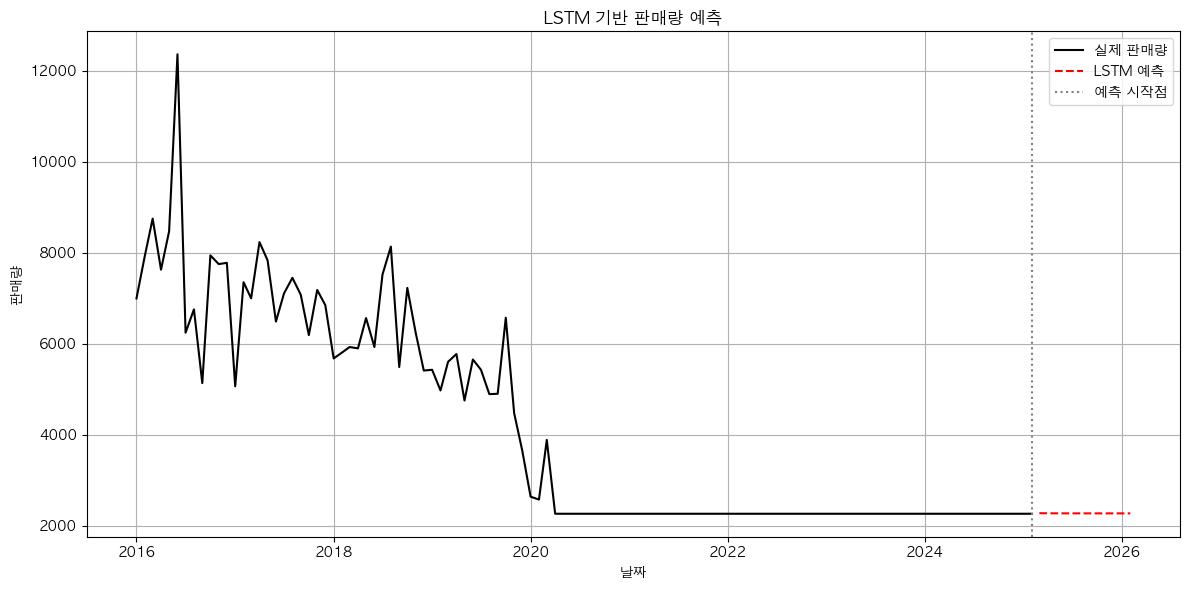

In [161]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# 1. 데이터 준비 함수
def prepare_lstm_data(series, time_steps=12):
    values = series['y'].values.reshape(-1, 1)
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(values)

    X, y = [], []
    for i in range(time_steps, len(scaled)):
        X.append(scaled[i-time_steps:i])
        y.append(scaled[i])
    X, y = np.array(X), np.array(y)
    return X, y, scaler

# 2. 모델 정의 및 학습
def train_lstm_model(X, y, units=50, epochs=600, batch_size=16):
    model = Sequential()
    model.add(LSTM(units=units, activation='relu', input_shape=(X.shape[1], X.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=1)
    return model

# 3. 미래 예측
def forecast_lstm(model, series, forecast_months, scaler, time_steps=12):
    data = scaler.transform(series['y'].values.reshape(-1, 1))
    last_sequence = data[-time_steps:]

    predictions = []
    for _ in range(forecast_months):
        input_seq = last_sequence.reshape(1, time_steps, 1)
        pred = model.predict(input_seq, verbose=0)
        predictions.append(pred[0, 0])
        last_sequence = np.append(last_sequence[1:], pred, axis=0)

    forecast_scaled = np.array(predictions).reshape(-1, 1)
    forecast_values = scaler.inverse_transform(forecast_scaled)

    last_date = series.index[-1]
    future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_months, freq='MS')

    result = pd.DataFrame({
        '연도': future_dates.year,
        '월': future_dates.month,
        '예측 판매량': forecast_values.flatten()
    })
    return result

# 4. 시각화 함수
def plot_lstm_forecast(series, forecast_df, car_name, forecast_months, save_path=None):
    forecast_index = pd.to_datetime(forecast_df['연도'].astype(str) + '-' + forecast_df['월'].astype(str))
    forecast_values = forecast_df['예측 판매량'].values

    plt.figure(figsize=(12, 6))
    plt.plot(series.index, series['y'], label='실제 판매량', color='black')
    plt.plot(forecast_index, forecast_values, label='LSTM 예측', color='red', linestyle='--')
    plt.axvline(x=series.index[-1], color='gray', linestyle=':', label='예측 시작점')
    plt.title("LSTM 기반 판매량 예측")
    plt.xlabel("날짜")
    plt.ylabel("판매량")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    save_path = f"../../images/result/{car_name} LSTM 차종별 판매량 예측_{forecast_months}개월.png"

    # 이미지 저장
    if save_path:
        plt.savefig(save_path, dpi=300)  # 해상도 조정 가능
        print(f"그래프가 '{save_path}'로 저장되었습니다.")

    plt.show()

# 5. 실행 예시
file_path = "../../data/processed/현대_차종별판매실적_전처리.csv"
df = pd.read_csv(file_path)

# 전처리: 인덱스 통합
df['차종'] = df['차종'].astype(str) + '-' + df['거래 구분'].astype(str).str.zfill(2)
df = df.drop(columns=['차량 유형', '거래 구분'])
cols = ['차종'] + [col for col in df.columns if col != '차종']
df = df[cols]

car_name = "Avante (AD)-내수"
forecast_months = 12

car_data = df[df['차종'] == car_name].iloc[:, 1:].T
car_data.columns = ['y']
car_data.index = pd.to_datetime(car_data.index)
car_data = car_data.asfreq('MS')
car_data['y'] = pd.to_numeric(car_data['y'], errors='coerce')
car_data = car_data.dropna()

def get_model_path(car_name):
    return f"../../models/lstm_car_{car_name}_model.h5"

def get_scaler_path(car_name):
    return f"../../models/lstm_car_{car_name}_scaler.pkl"

def ensure_model(car_name):
    model_path = get_model_path(car_name)
    scaler_path = get_scaler_path(car_name)

    if os.path.exists(model_path) and os.path.exists(scaler_path):
        print(f"✅ 저장된 모델과 스케일러가 존재합니다: {model_path}")
        return True
    else:
        print(f"🚀 모델 또는 스케일러가 존재하지 않아 새로 학습합니다.")
        return False

status = ensure_model(car_name)

if status:
    lstm_model = load_model(f"../../models/lstm_car_{car_name}_model.h5", compile=False)
    scaler = joblib.load(f"../../models/lstm_car_{car_name}_scaler.pkl")
else:
    X, y, scaler = prepare_lstm_data(car_data)
    lstm_model = train_lstm_model(X, y)
    lstm_model.save(f"../../models/lstm_car_{car_name}_model.h5")
    joblib.dump(scaler, f"../../models/lstm_car_{car_name}_scaler.pkl")

lstm_forecast = forecast_lstm(lstm_model, car_data, forecast_months, scaler)
plot_lstm_forecast(car_data, lstm_forecast, car_name, forecast_months)

#### 공장별 판매량 예측 모델

🚀 모델 또는 스케일러가 존재하지 않아 새로 학습합니다.
Epoch 1/600


/opt/anaconda3/envs/hi/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2210  
Epoch 2/600
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1743 
Epoch 3/600
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1150
Epoch 4/600
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0785 
Epoch 5/600
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0311 
Epoch 6/600
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0411 
Epoch 7/600
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0311 
Epoch 8/600
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0314 
Epoch 9/600
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0308 
Epoch 10/600
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0308 
Epoch 11/600
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0274 
Epoch 12/600
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0261 
Epoch 13/600
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0242 
Epoch 14/600
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0290 
Epoch 15/600
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0284 
Epoch 16/600
7/7 ━━━━━━━━━━━━━

그래프가 '../../images/result/인도-i10-내수 LSTM 공장별 판매량 예측_12개월.png'로 저장되었습니다.


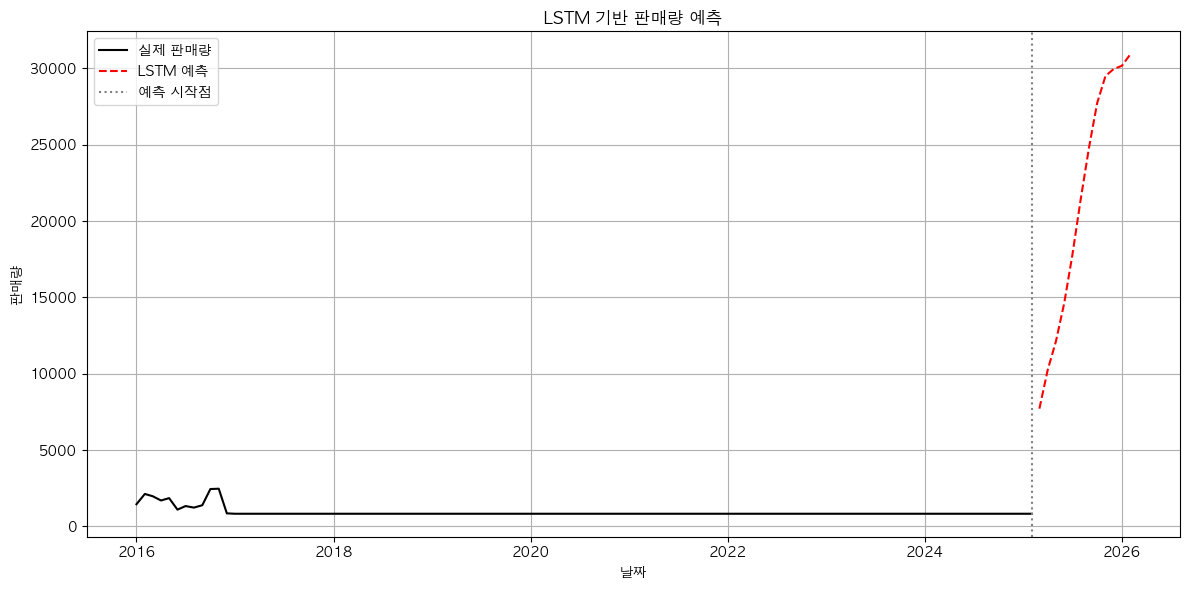

In [162]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# 1. 데이터 준비 함수
def prepare_lstm_data(series, time_steps=12):
    values = series['y'].values.reshape(-1, 1)
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(values)

    X, y = [], []
    for i in range(time_steps, len(scaled)):
        X.append(scaled[i-time_steps:i])
        y.append(scaled[i])
    X, y = np.array(X), np.array(y)
    return X, y, scaler

# 2. 모델 정의 및 학습
def train_lstm_model(X, y, units=50, epochs=600, batch_size=16):
    model = Sequential()
    model.add(LSTM(units=units, activation='relu', input_shape=(X.shape[1], X.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=1)
    return model

# 3. 미래 예측
def forecast_lstm(model, series, forecast_months, scaler, time_steps=12):
    data = scaler.transform(series['y'].values.reshape(-1, 1))
    last_sequence = data[-time_steps:]

    predictions = []
    for _ in range(forecast_months):
        input_seq = last_sequence.reshape(1, time_steps, 1)
        pred = model.predict(input_seq, verbose=0)
        predictions.append(pred[0, 0])
        last_sequence = np.append(last_sequence[1:], pred, axis=0)

    forecast_scaled = np.array(predictions).reshape(-1, 1)
    forecast_values = scaler.inverse_transform(forecast_scaled)

    last_date = series.index[-1]
    future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_months, freq='MS')

    result = pd.DataFrame({
        '연도': future_dates.year,
        '월': future_dates.month,
        '예측 판매량': forecast_values.flatten()
    })
    return result

# 4. 시각화 함수
def plot_lstm_forecast(series, forecast_df, plant_name, forecast_months, save_path=None):
    forecast_index = pd.to_datetime(forecast_df['연도'].astype(str) + '-' + forecast_df['월'].astype(str))
    forecast_values = forecast_df['예측 판매량'].values

    plt.figure(figsize=(12, 6))
    plt.plot(series.index, series['y'], label='실제 판매량', color='black')
    plt.plot(forecast_index, forecast_values, label='LSTM 예측', color='red', linestyle='--')
    plt.axvline(x=series.index[-1], color='gray', linestyle=':', label='예측 시작점')
    plt.title("LSTM 기반 판매량 예측")
    plt.xlabel("날짜")
    plt.ylabel("판매량")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    save_path = f"../../images/result/{plant_name} LSTM 공장별 판매량 예측_{forecast_months}개월.png"

    # 이미지 저장
    if save_path:
        plt.savefig(save_path, dpi=300)  # 해상도 조정 가능
        print(f"그래프가 '{save_path}'로 저장되었습니다.")

    plt.show()

# 5. 실행 예시
file_path = "../../data/processed/현대_해외공장판매실적_전처리.csv"
df = pd.read_csv(file_path)

# 전처리: 인덱스 통합
df['공장명(국가)'] = df['공장명(국가)'].astype(str) + '-' + df['차종'].astype(str).str.zfill(2) + '-' + df['거래 구분'].astype(str).str.zfill(2)
df = df.drop(columns=['차종', '거래 구분'])
cols = ['공장명(국가)'] + [col for col in df.columns if col != '공장명(국가)']
df = df[cols]

plant_name = "인도-i10-내수"
forecast_months = 12

plant_data = df[df['공장명(국가)'] == plant_name].iloc[:, 1:].T
plant_data.columns = ['y']
plant_data.index = pd.to_datetime(plant_data.index)
plant_data = plant_data.asfreq('MS')
plant_data['y'] = pd.to_numeric(plant_data['y'], errors='coerce')
plant_data = plant_data.dropna()

def get_model_path(plant_name):
    return f"../../models/lstm_plant_{plant_name}_model.h5"

def get_scaler_path(plant_name):
    return f"../../models/lstm_plant_{plant_name}_scaler.pkl"

def ensure_model(plant_name):
    model_path = get_model_path(plant_name)
    scaler_path = get_scaler_path(plant_name)

    if os.path.exists(model_path) and os.path.exists(scaler_path):
        print(f"✅ 저장된 모델과 스케일러가 존재합니다: {model_path}")
        return True
    else:
        print(f"🚀 모델 또는 스케일러가 존재하지 않아 새로 학습합니다.")
        return False

status = ensure_model(plant_name)

if status:
    lstm_model = load_model(f"../../models/lstm_plant_{plant_name}_model.h5", compile=False)
    scaler = joblib.load(f"../../models/lstm_plant_{plant_name}_scaler.pkl")
else:
    X, y, scaler = prepare_lstm_data(region_data)
    lstm_model = train_lstm_model(X, y)
    lstm_model.save(f"../../models/lstm_plant_{plant_name}_model.h5")
    joblib.dump(scaler, f"../../models/lstm_plant_{plant_name}_scaler.pkl")

lstm_forecast = forecast_lstm(lstm_model, plant_data, forecast_months, scaler)
plot_lstm_forecast(plant_data, lstm_forecast, plant_name, forecast_months)

## 아래는 덜 좋지만 빠른 모델

#### 지역별 수출량 모델

🚀 모델이 존재하지 않아 새로 학습합니다: ../../models/sarimax_region_미국_model.pkl


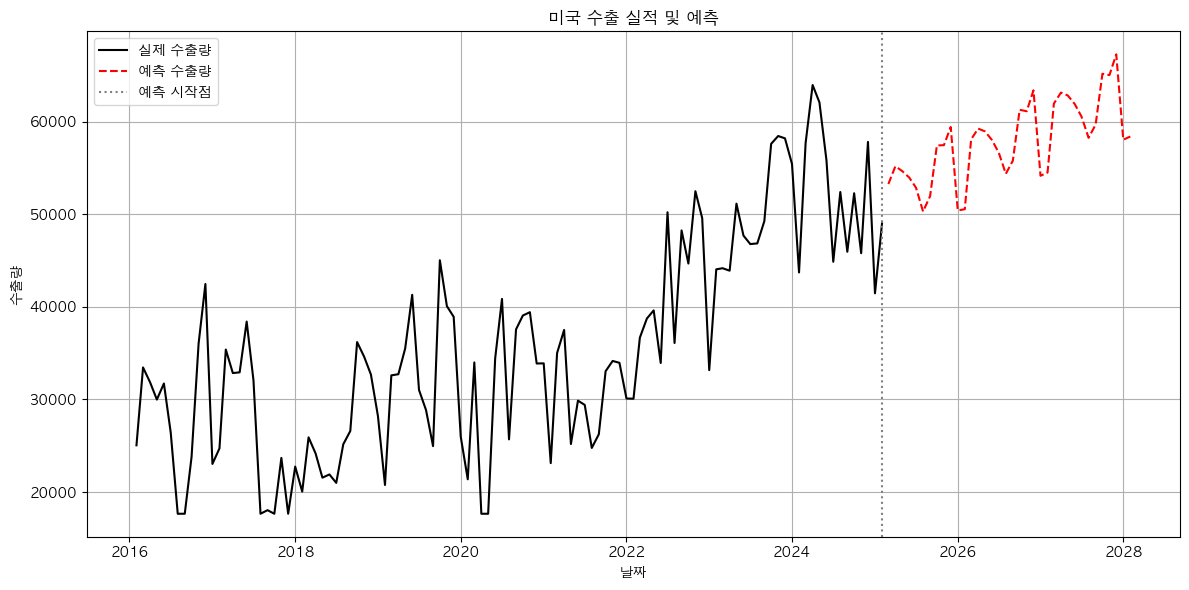

그래프가 '../../images/result/미국 SARIMAX 지역별 판매량 예측.png'로 저장되었습니다.


<Figure size 640x480 with 0 Axes>

In [163]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
import os
import joblib

def load_data(file_path):
    df = pd.read_csv(file_path)
    return df

def prepare_region_series(df, region_name):
    region_data = df[df['지역명'] == region_name].iloc[:, 2:].T
    region_data.columns = ['y']
    region_data.index = pd.to_datetime(region_data.index)
    region_data = region_data.asfreq('MS')
    return region_data

def train_sarimax_model(series):
    # (p,d,q) = (1,1,1), (P,D,Q,s) = (1,1,1,12): 기본 계절성 모델
    model = SARIMAX(series, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    fit_model = model.fit(disp=False)
    return fit_model

def forecast_future(fit_model, series, periods):
    last_date = series.index[-1]
    future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=periods, freq='MS')
    forecast = fit_model.get_forecast(steps=periods)
    forecast_mean = forecast.predicted_mean

    result = pd.DataFrame({
        '연도': future_dates.year,
        '월': future_dates.month,
        '예측 수출량': forecast_mean.values
    })
    return result

def plot_series_with_forecast(series, forecast_result, region_name, save_path=None):
    # 실제값
    actual = series.copy()
    
    # 예측 날짜 구성
    forecast_index = pd.to_datetime(forecast_result['연도'].astype(str) + '-' + forecast_result['월'].astype(str))
    forecast_series = pd.Series(forecast_result['예측 수출량'].values, index=forecast_index)
    
    # 시각화
    plt.figure(figsize=(12, 6))
    plt.plot(actual.index, actual['y'], label='실제 수출량', color='black')
    plt.plot(forecast_series.index, forecast_series.values, label='예측 수출량', color='red', linestyle='--')
    
    plt.axvline(x=actual.index[-1], color='gray', linestyle=':', label='예측 시작점')
    plt.title(f"{region_name} 수출 실적 및 예측")
    plt.xlabel("날짜")
    plt.ylabel("수출량")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    save_path = f"../../images/result/{region_name} SARIMAX 지역별 판매량 예측.png"

    # 이미지 저장
    if save_path:
        plt.savefig(save_path, dpi=300)  # 해상도 조정 가능
        print(f"그래프가 '{save_path}'로 저장되었습니다.")

    plt.show()



file_path = "../../data/processed/현대_지역별수출실적_전처리.csv"  # 본인 환경에 맞게 경로 설정

df = load_data(file_path)

# 기존 컬럼 제거
df = df.drop(columns=['대륙'])

# '날짜' 컬럼을 맨 앞으로 이동
cols = ['지역명'] + [col for col in df.columns if col != '지역명']
df = df[cols]

region_name = "미국"  # 입력받을 지역명
forecast_months = 36   # 예측할 개월 수


def get_model_path(region_name):
    return f"../../models/sarimax_region_{region_name}_model.pkl"

def ensure_model(region_name):
    model_path = get_model_path(region_name)

    if os.path.exists(model_path):
        print(f"✅ 저장된 모델이 존재합니다: {model_path}")
        return True
    else:
        print(f"🚀 모델이 존재하지 않아 새로 학습합니다: {model_path}")
        return False

status = ensure_model(region_name)

if status:
    model = joblib.load(get_model_path(region_name))
else:
    region_series = prepare_region_series(df, region_name)
    model = train_sarimax_model(region_series)
    joblib.dump(model, f"../../models/sarimax_region_{region_name}_model.pkl")

forecast_result = forecast_future(model, region_series, forecast_months)
plot_series_with_forecast(region_series, forecast_result, region_name)

#### 차종별 판매량 모델

🚀 모델이 존재하지 않아 새로 학습합니다: ../../models/sarimax_car_Avante (AD)-내수_model.pkl


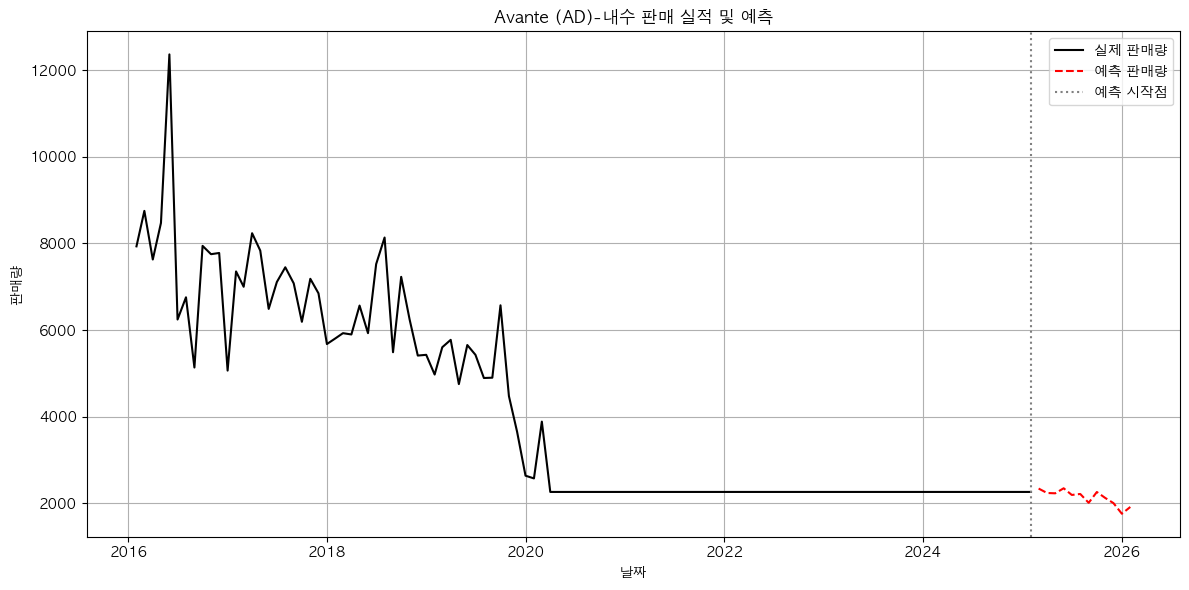

그래프가 '../../images/result/Avante (AD)-내수 SARIMAX 차종별 판매량 예측.png'로 저장되었습니다.


<Figure size 640x480 with 0 Axes>

In [164]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
import os
import joblib

def load_data(file_path):
    df = pd.read_csv(file_path)
    return df

def prepare_car_series(df, car_name):
    car_data = df[df['차종'] == car_name].iloc[:, 2:].T
    car_data.columns = ['y']
    car_data.index = pd.to_datetime(car_data.index)
    car_data = car_data.asfreq('MS')
    return car_data

def train_sarimax_model(series):
    # (p,d,q) = (1,1,1), (P,D,Q,s) = (1,1,1,12): 기본 계절성 모델
    model = SARIMAX(series, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    fit_model = model.fit(disp=False)
    return fit_model

def forecast_future(fit_model, series, periods):
    last_date = series.index[-1]
    future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=periods, freq='MS')
    forecast = fit_model.get_forecast(steps=periods)
    forecast_mean = forecast.predicted_mean

    result = pd.DataFrame({
        '연도': future_dates.year,
        '월': future_dates.month,
        '예측 판매량': forecast_mean.values
    })
    return result

def plot_series_with_forecast(series, forecast_result, car_name, save_path=None):
    # 실제값
    actual = series.copy()
    
    # 예측 날짜 구성
    forecast_index = pd.to_datetime(forecast_result['연도'].astype(str) + '-' + forecast_result['월'].astype(str))
    forecast_series = pd.Series(forecast_result['예측 판매량'].values, index=forecast_index)
    
    # 시각화
    plt.figure(figsize=(12, 6))
    plt.plot(actual.index, actual['y'], label='실제 판매량', color='black')
    plt.plot(forecast_series.index, forecast_series.values, label='예측 판매량', color='red', linestyle='--')
    
    plt.axvline(x=actual.index[-1], color='gray', linestyle=':', label='예측 시작점')
    plt.title(f"{car_name} 판매 실적 및 예측")
    plt.xlabel("날짜")
    plt.ylabel("판매량")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    save_path = f"../../images/result/{car_name} SARIMAX 차종별 판매량 예측.png"

    # 이미지 저장
    if save_path:
        plt.savefig(save_path, dpi=300)  # 해상도 조정 가능
        print(f"그래프가 '{save_path}'로 저장되었습니다.")

    plt.show()



file_path = "../../data/processed/현대_차종별판매실적_전처리.csv"  # 본인 환경에 맞게 경로 설정

df = load_data(file_path)

# 전처리: 인덱스 통합
df['차종'] = df['차종'].astype(str) + '-' + df['거래 구분'].astype(str).str.zfill(2)
df = df.drop(columns=['차량 유형', '거래 구분'])
cols = ['차종'] + [col for col in df.columns if col != '차종']
df = df[cols]

car_name = "Avante (AD)-내수"
forecast_months = 12


def get_model_path(car_name):
    return f"../../models/sarimax_car_{car_name}_model.pkl"

def ensure_model(car_name):
    model_path = get_model_path(car_name)

    if os.path.exists(model_path):
        print(f"✅ 저장된 모델이 존재합니다: {model_path}")
        return True
    else:
        print(f"🚀 모델이 존재하지 않아 새로 학습합니다: {model_path}")
        return False

status = ensure_model(car_name)

if status:
    model = joblib.load(get_model_path(car_name))
else:
    car_series = prepare_car_series(df, car_name)
    model = train_sarimax_model(car_series)
    joblib.dump(model, f"../../models/sarimax_car_{car_name}_model.pkl")

forecast_result = forecast_future(model, car_series, forecast_months)
plot_series_with_forecast(car_series, forecast_result, car_name)

#### 공장별 판매량 모델

🚀 모델이 존재하지 않아 새로 학습합니다: ../../models/sarimax_plant_인도-Eon-내수_model.pkl


/opt/anaconda3/envs/hi/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


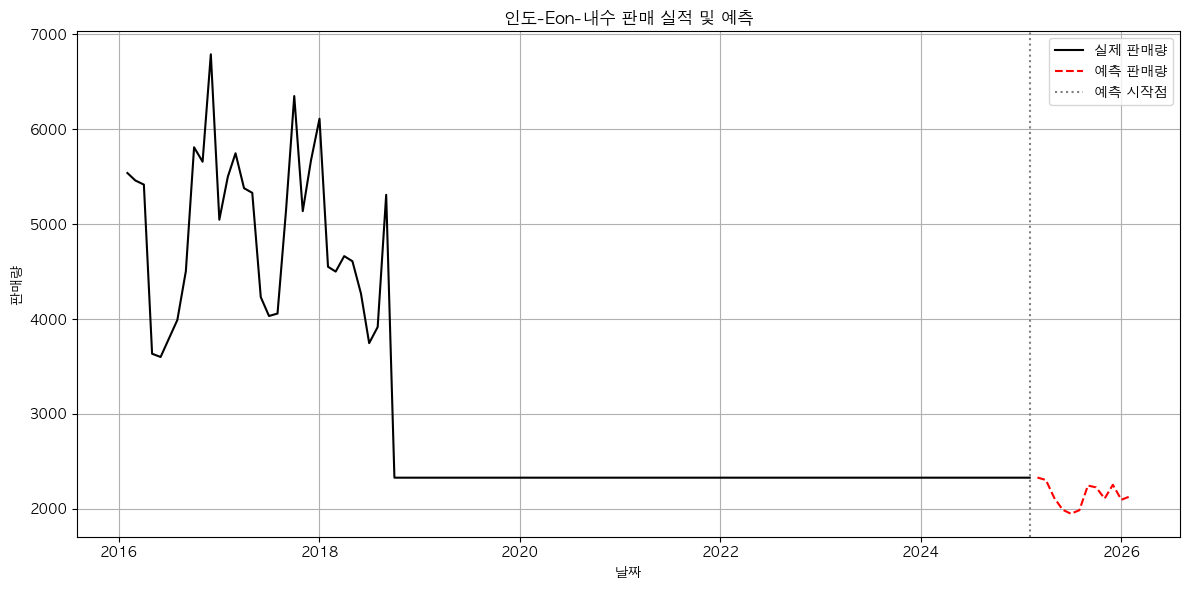

그래프가 '../../images/result/인도-Eon-내수 SARIMAX 공장별 판매량 예측.png'로 저장되었습니다.


<Figure size 640x480 with 0 Axes>

In [165]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
import os
import joblib

def load_data(file_path):
    df = pd.read_csv(file_path)
    return df

def prepare_plant_series(df, plant_name):
    plant_data = df[df['공장명(국가)'] == plant_name].iloc[:, 2:].T
    plant_data.columns = ['y']
    plant_data.index = pd.to_datetime(plant_data.index)
    plant_data = plant_data.asfreq('MS')
    return plant_data

def train_sarimax_model(series):
    # (p,d,q) = (1,1,1), (P,D,Q,s) = (1,1,1,12): 기본 계절성 모델
    model = SARIMAX(series, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    fit_model = model.fit(disp=False)
    return fit_model

def forecast_future(fit_model, series, periods):
    last_date = series.index[-1]
    future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=periods, freq='MS')
    forecast = fit_model.get_forecast(steps=periods)
    forecast_mean = forecast.predicted_mean

    result = pd.DataFrame({
        '연도': future_dates.year,
        '월': future_dates.month,
        '예측 판매량': forecast_mean.values
    })
    return result

def plot_series_with_forecast(series, forecast_result, plant_name, save_path=None):
    # 실제값
    actual = series.copy()
    
    # 예측 날짜 구성
    forecast_index = pd.to_datetime(forecast_result['연도'].astype(str) + '-' + forecast_result['월'].astype(str))
    forecast_series = pd.Series(forecast_result['예측 판매량'].values, index=forecast_index)
    
    # 시각화
    plt.figure(figsize=(12, 6))
    plt.plot(actual.index, actual['y'], label='실제 판매량', color='black')
    plt.plot(forecast_series.index, forecast_series.values, label='예측 판매량', color='red', linestyle='--')
    
    plt.axvline(x=actual.index[-1], color='gray', linestyle=':', label='예측 시작점')
    plt.title(f"{plant_name} 판매 실적 및 예측")
    plt.xlabel("날짜")
    plt.ylabel("판매량")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    save_path = f"../../images/result/{plant_name} SARIMAX 공장별 판매량 예측.png"

    # 이미지 저장
    if save_path:
        plt.savefig(save_path, dpi=300)  # 해상도 조정 가능
        print(f"그래프가 '{save_path}'로 저장되었습니다.")

    plt.show()


file_path = "../../data/processed/현대_해외공장판매실적_전처리.csv"
df = pd.read_csv(file_path)

# 전처리: 인덱스 통합
df['공장명(국가)'] = df['공장명(국가)'].astype(str) + '-' + df['차종'].astype(str).str.zfill(2) + '-' + df['거래 구분'].astype(str).str.zfill(2)
df = df.drop(columns=['차종', '거래 구분'])
cols = ['공장명(국가)'] + [col for col in df.columns if col != '공장명(국가)']
df = df[cols]

plant_name = "인도-Eon-내수"
forecast_months = 12



def get_model_path(plant_name):
    return f"../../models/sarimax_plant_{plant_name}_model.pkl"

def ensure_model(plant_name):
    model_path = get_model_path(plant_name)

    if os.path.exists(model_path):
        print(f"✅ 저장된 모델이 존재합니다: {model_path}")
        return True
    else:
        print(f"🚀 모델이 존재하지 않아 새로 학습합니다: {model_path}")
        return False

status = ensure_model(plant_name)

if status:
    model = joblib.load(get_model_path(plant_name))
else:
    plant_series = prepare_plant_series(df, plant_name)
    model = train_sarimax_model(plant_series)
    joblib.dump(model, f"../../models/sarimax_plant_{plant_name}_model.pkl")

forecast_result = forecast_future(model, plant_series, forecast_months)
plot_series_with_forecast(plant_series, forecast_result, plant_name)